# DSC 511: Project
# Argentina houses' price prediction

In [1]:
! pip install pyspark seaborn

In [2]:
# for visual studio
# import sys
# import subprocess

# subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])


In [2]:
# libraries

import sklearn
from sklearn.impute import KNNImputer
import pandas as pd
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark import SparkConf

## Read Dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/Colab Notebooks/Project/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# configure Spark settings for memory management
conf = (SparkConf().set("spark.executor.memory", "4g").set("spark.driver.memory", "4g"))


# create Spark Session
spark = SparkSession.builder.appName("Project511").master("local[*]").config(conf=conf).getOrCreate()

# define a schema for the csv dataset to ensure all data types are correctly interpreted by Spark
schema = StructType( [
  StructField("id", StringType(), True),
  StructField("ad_type", StringType(), True),
  StructField("start_date", StringType(), True),
  StructField("end_date", StringType(), True),
  StructField("created_on", StringType(), True),
  StructField("lat", FloatType(), True),
  StructField("lon", FloatType(), True),
  StructField("l1", StringType(), True),
  StructField("l2", StringType(), True),
  StructField("l3", StringType(), True),
  StructField("l4", StringType(), True),
  StructField("l5", StringType(), True),
  StructField("l6", StringType(), True),
  StructField("rooms", IntegerType(), True),
  StructField("bedrooms", IntegerType(), True),
  StructField("bathrooms", IntegerType(), True),
  StructField("surface_total", DoubleType(), True),
  StructField("surface_covered", DoubleType(), True),
  StructField("price", DoubleType(), True),
  StructField("currency", StringType(), True),
  StructField("price_period", StringType(), True),
  StructField("title", StringType(), True),
  StructField("description", StringType(), True),
  StructField("property_type", StringType(), True),
  StructField("operation_type", StringType(), True)])

In [5]:
# read the csv file appropriately in order to handle specific characters that are included in some of our columns
df = spark.read.format("csv").option("header", "true").option("multiLine", "true").option("escape", "\"").option("quote", "\"").schema(schema) \
    .load(google_drive_path + 'ar_properties.csv', header=True, inferSchema=True)

# clean the id column by removing HTML tags and other unwanted characters and replace new lines within the field with space
df = df.withColumn("id", regexp_replace("id", "<.*?>", "")).withColumn("id", regexp_replace("id", "[\r\n]+", " "))

In [6]:
df.show()

+--------------------+---------+----------+----------+----------+----------+----------+---------+--------------------+--------------------+----------------+----+----+-----+--------+---------+-------------+---------------+-----+--------+------------+--------------------+--------------------+-------------+-----------------+
|                  id|  ad_type|start_date|  end_date|created_on|       lat|       lon|       l1|                  l2|                  l3|              l4|  l5|  l6|rooms|bedrooms|bathrooms|surface_total|surface_covered|price|currency|price_period|               title|         description|property_type|   operation_type|
+--------------------+---------+----------+----------+----------+----------+----------+---------+--------------------+--------------------+----------------+----+----+-----+--------+---------+-------------+---------------+-----+--------+------------+--------------------+--------------------+-------------+-----------------+
|wdQ5hWhv8P14T7Sh9...|Propie

In [7]:
df.count()

1000000

## Preprocessing

Missing Values

To quantify the completeness of the dataset we calculated the percentage of missing values in each column. This analysis helps identify data quality issues and informs necessary preprocessing steps like data imputation or deletion.

In [8]:
# percentage of na's in each column
na_counts = df.select([(count(when(isnan(c) | col(c).isNull(), c)) / count('*') * 100).alias(c) for c in df.columns])

# print the results in a more readable format - in percentage
for row in na_counts.collect():
    for column, percentage in row.asDict().items():
        print(f"Percentage of NAs in {column}: {percentage:.2f}%")

Percentage of NAs in id: 0.00%
Percentage of NAs in ad_type: 0.00%
Percentage of NAs in start_date: 0.00%
Percentage of NAs in end_date: 0.00%
Percentage of NAs in created_on: 0.00%
Percentage of NAs in lat: 15.08%
Percentage of NAs in lon: 15.17%
Percentage of NAs in l1: 0.00%
Percentage of NAs in l2: 0.00%
Percentage of NAs in l3: 5.33%
Percentage of NAs in l4: 76.05%
Percentage of NAs in l5: 99.50%
Percentage of NAs in l6: 100.00%
Percentage of NAs in rooms: 47.36%
Percentage of NAs in bedrooms: 53.38%
Percentage of NAs in bathrooms: 22.33%
Percentage of NAs in surface_total: 62.05%
Percentage of NAs in surface_covered: 61.85%
Percentage of NAs in price: 3.69%
Percentage of NAs in currency: 3.83%
Percentage of NAs in price_period: 63.70%
Percentage of NAs in title: 0.00%
Percentage of NAs in description: 0.00%
Percentage of NAs in property_type: 0.00%
Percentage of NAs in operation_type: 0.00%


- No Missing Data: Columns like id, ad_type, and operation_type have 0% missing values, indicating complete records in these critical fields.
- High Missing Data: l6 has 100% missing data, and l5 has 99.5% missing, suggesting these columns are not useful without further context or additional data.
- Columns like l4, surface_total, surface_covered, and price_period also exhibit high percentages of missing values (over 60%), indicating substantial gaps in property details that could impact analysis or model training.
- Moderate Missing Data: rooms, bedrooms, and bathrooms show significant missing data, which could affect analyses related to property size and capacity.
- Low Missing Data: lat, lon.
- Very low Missing Data: price, currency, l3, which can ve dropped.

### Drop Columns

The following steps include dropping irrelevant columns, filtering rows based on specific conditions, and handling partially missing values. Additionally, they include steps for correcting data inconsistencies, and ensure logical coherence among data attributes.

In [9]:
# l4, l5, l6 refer to more specific location of the house like address, block, etc so we drop them
# we keep l1, l2, l3 which refer to the region, main locality
# drop id as it's also irrelevant and not even unique

df = df.drop("l4", "l5", "l6", "id")

In [10]:
# currency nan < 10% => drop rows
df = df.na.drop(subset=["currency"])

"ad_type" column

In [11]:

df.select('ad_type').distinct().show() # only one unique value -> drop

+---------+
|  ad_type|
+---------+
|Propiedad|
+---------+



In [12]:
df = df.drop("ad_type")

'l1' column - Country

In [13]:
# we want only houses in argentina
df.groupBy('l1').count().show()

+--------------+------+
|            l1| count|
+--------------+------+
|     Argentina|947979|
|       Uruguay| 12962|
|Estados Unidos|   688|
|        Brasil|    90|
+--------------+------+



In [14]:
# filter out any other country
df = df.filter(col("l1") == "Argentina")

In [15]:
df = df.drop("l1") # => only one value remained

'Bedrooms' Column

In [16]:
df.groupBy("bedrooms").count().sort("bedrooms").show()

+--------+------+
|bedrooms| count|
+--------+------+
|    NULL|512420|
|     -16|     1|
|      -2|     1|
|      -1|     5|
|       0| 28409|
|       1|140490|
|       2|122037|
|       3| 93157|
|       4| 36824|
|       5|  9590|
|       6|  3112|
|       7|   794|
|       8|   380|
|       9|   116|
|      10|   268|
|      11|    44|
|      12|    74|
|      13|    17|
|      14|    23|
|      15|    15|
+--------+------+
only showing top 20 rows



In [17]:
# [-1, -2, -16, 900, 335, 129, 100, 99]

# remove rows with bedrooms < 0 and some extreme values
df = df.filter(((col("bedrooms") >= 0) & (col("bedrooms") < 100)) | (col("bedrooms").isNull()))

In [18]:
df.count()

947958

In [19]:
# Bedrooms are larger than rooms which doesnt make sense thus we remove these rows
# we also keep the nulls
df = df.filter((col("bedrooms").isNull()) | (col("rooms").isNull()) | (col("bedrooms") <= col("rooms")))


In [20]:
df.count()

945266

In [21]:
# bathrooms are larger than rooms which doesnt make sense thus we remove these rows
# we also keep the nulls
df = df.filter((col("bathrooms").isNull()) | (col("rooms").isNull()) | (col("bathrooms") <= col("rooms")))

In [22]:
df.count()

937022

Price Period

In [23]:
df.select('price_period').distinct()

DataFrame[price_period: string]

In [24]:
# # we dont care about the time period of the payments => drop
# # most of the instances are also null or mensual => uninformative
df = df.drop('price_period')

Price

In [25]:
# na of target variable = 3.69% < 10% => drop rows
df = df.na.drop(subset=["price"])

In [26]:
# Take only the rows with the price more than 0
df = df.filter(col('price') > 0)

In [27]:
df.count()

936882

### Handling missing values

#### Lat and Lon

- Nature of the Features: Latitude and longitude are coordinates that together define a unique location. Dropping one might lead to loss of valuable geographic information that could be predictive of our target variable (e.g., house prices might be highly dependent on specific locations).
- Model Dependency: Some models are more sensitive to multicollinearity (high correlation among predictor variables) than others. For instance, linear regression models can have issues with multicollinearity, leading to unstable coefficients. However, tree-based models like decision trees, random forests, and gradient boosting machines are generally less affected by multicollinearity because they are splitting the data on the most important variables one at a time.
- Feature Engineering: Instead of dropping one of the coordinates, we can combine them into a single feature that captures both. These transformations can help mitigate the impact of multicollinearity while preserving essential information.

1. Fill na with mean
2. Combine lat and lon to one feature

Calculate and use the mean values of latitude and longitude to fill missing entries. This approach maintains the general geographical characteristics of the dataset without introducing bias that might occur with the deletion of these rows.

In [ ]:
# function to replace NaN values with null for more accurate computation of statistics such as mean
def replace_nan_with_null(df, columns):
    for column in columns:
        df = df.withColumn(column, when(isnan(col(column)), None).otherwise(col(column)))
    return df

In [28]:
# replace NaN values in latitude and longitude columns
df = replace_nan_with_null(df, ["lat", "lon"])

# calculate mean, excluding nulls
mean_values = df.agg(mean(col("lat")).alias("mean_lat"),mean(col("lon")).alias("mean_lon")).first()  # get the 1st row object

mean_lat = mean_values["mean_lat"]
mean_lon = mean_values["mean_lon"]

# fill missing values in lat and lon with their respective mean values
df = df.na.fill({"lat": mean_lat,"lon": mean_lon})


df.show()


+----------+----------+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------+--------------------+--------------------+-------------+-----------------+
|start_date|  end_date|created_on|       lat|       lon|                  l2|                  l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|    price|currency|               title|         description|property_type|   operation_type|
+----------+----------+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------+--------------------+--------------------+-------------+-----------------+
|2020-12-25|2021-02-13|2020-12-25|-24.825768|-65.470795|               Salta|               Salta| NULL|    NULL|     NULL|        324.0|          324.0|2000000.0|     ARS|TERRENO + VENTA +...|Corredor Responsa...|         Lote|            Venta|
|2020-12-25|

In [29]:
# combining lat and lon into a single column - list
df = df.withColumn("coordinates", array("lat", "lon"))

In [30]:
df = df.drop("lat", "lon")

In [31]:
df.show()

+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------+--------------------+--------------------+-------------+-----------------+--------------------+
|start_date|  end_date|created_on|                  l2|                  l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|    price|currency|               title|         description|property_type|   operation_type|         coordinates|
+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------+--------------------+--------------------+-------------+-----------------+--------------------+
|2020-12-25|2021-02-13|2020-12-25|               Salta|               Salta| NULL|    NULL|     NULL|        324.0|          324.0|2000000.0|     ARS|TERRENO + VENTA +...|Corredor Responsa...|         Lote|            Venta|[-24.825768, -65....|
|2020-12-25|2021

#### l3

In [32]:
# drop rows where 'l3' location data is missing
df = df.na.drop(subset=["l3"])

In [33]:
df.printSchema()

root
 |-- start_date: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- created_on: string (nullable = true)
 |-- l2: string (nullable = true)
 |-- l3: string (nullable = true)
 |-- rooms: integer (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- surface_total: double (nullable = true)
 |-- surface_covered: double (nullable = true)
 |-- price: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- operation_type: string (nullable = true)
 |-- coordinates: array (nullable = false)
 |    |-- element: float (containsNull = false)



In [34]:
# function to calculate the percentage of missing values across different data types
def na_percentage(c, dtype):
    if dtype in ['integer', 'double']:  # check both NaN and null for numeric types
        return ((count(when(isnan(c) | col(c).isNull(), c)) / count('*')) * 100).alias(c)
    elif dtype == 'array':  # check if the array is empty or null 
        return ((count(when(col(c).isNull() | (size(col(c)) == 0), c)) / count('*')) * 100).alias(c)
    else:  # for all other types just check for null
        return (count(when(col(c).isNull(), c)) / count('*') * 100).alias(c)


In [35]:
# calculate the % of missing values for each column 
na_counts = df.select([na_percentage(c, dtype) for c, dtype in df.dtypes])

# print the results in percentage
for row in na_counts.collect():
    for column, percentage in row.asDict().items():
        print(f"Percentage of NAs in {column}: {percentage:.4f}%")


Percentage of NAs in start_date: 0.0000%
Percentage of NAs in end_date: 0.0000%
Percentage of NAs in created_on: 0.0000%
Percentage of NAs in l2: 0.0000%
Percentage of NAs in l3: 0.0000%
Percentage of NAs in rooms: 46.9162%
Percentage of NAs in bedrooms: 53.1813%
Percentage of NAs in bathrooms: 22.1505%
Percentage of NAs in surface_total: 61.8157%
Percentage of NAs in surface_covered: 61.6571%
Percentage of NAs in price: 0.0000%
Percentage of NAs in currency: 0.0000%
Percentage of NAs in title: 0.0000%
Percentage of NAs in description: 0.0015%
Percentage of NAs in property_type: 0.0000%
Percentage of NAs in operation_type: 0.0000%
Percentage of NAs in coordinates: 0.0000%


#### Description

In [36]:
# drop rows with missing values in the 'description' column
df = df.dropna(subset=['description'])

#### Currency Conversion

The next step, involves the currency conversion to unify financial metrics across different regions – main goal is to convert all currencies to euro in order for the properties’ prices to be comparable.

In [37]:
df.select("start_date").distinct().orderBy("start_date", ascending = False).show()

+----------+
|start_date|
+----------+
|2021-01-14|
|2021-01-13|
|2021-01-12|
|2021-01-11|
|2021-01-10|
|2021-01-09|
|2021-01-08|
|2021-01-07|
|2021-01-06|
|2021-01-05|
|2021-01-04|
|2021-01-02|
|2021-01-01|
|2020-12-31|
|2020-12-30|
|2020-12-29|
|2020-12-27|
|2020-12-26|
|2020-12-25|
|2020-12-24|
+----------+
only showing top 20 rows



In [38]:
df.agg(min("start_date"), max("start_date")).show()

+---------------+---------------+
|min(start_date)|max(start_date)|
+---------------+---------------+
|     2019-12-22|     2021-01-14|
+---------------+---------------+



In [39]:
# make the start_date as a DateType()
df = df.withColumn("start_date", F.col("start_date").cast(DateType()))

In [40]:
# categorize the date into first or last six months of the year in order to match the corresponding currency exchange rate at the time
df = df.withColumn("period", F.when(F.month("start_date") <= 6, "first_6_months").otherwise("last_6_months"))

In [41]:
# schema for the exchange rates df
schema = StructType([
    StructField("currency", StringType(), True),
    StructField("period", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("rate_to_euro", DoubleType(), True)])

# create the df with the predefined exchange rates for the currencies ARS, PEN, USD and UYU
exchange_rates = spark.createDataFrame(
    [
        ("ARS", "first_6_months", 2019, 0.0210), ("ARS", "last_6_months", 2019, 0.0157),
        ("ARS", "first_6_months", 2020, 0.0143), ("ARS", "last_6_months", 2020, 0.0114),
        ("ARS", "first_6_months", 2021, 0.0096), ("ARS", "last_6_months", 2021, 0.0087),
        ("PEN", "first_6_months", 2019,  0.267), ("PEN", "last_6_months", 2019, 0.263),
        ("PEN", "first_6_months", 2020, 0.280), ("PEN", "last_6_months", 2020, 0.275),
        ("PEN", "first_6_months", 2021, 0.290), ("PEN", "last_6_months", 2021, 0.285),
        ("USD", "first_6_months", 2019, 0.890), ("USD", "last_6_months", 2019, 0.875),
        ("USD", "first_6_months", 2020, 0.920), ("USD", "last_6_months", 2020, 0.910),
        ("USD", "first_6_months", 2021, 0.840), ("USD", "last_6_months", 2021, 0.825),
        ("UYU", "first_6_months", 2019, 0.025), ("UYU", "last_6_months", 2019, 0.024),
        ("UYU", "first_6_months", 2020, 0.023), ("UYU", "last_6_months", 2020, 0.022),
        ("UYU", "first_6_months", 2021, 0.021), ("UYU", "last_6_months", 2021, 0.020)
    ],
    schema)


exchange_rates.show()

+--------+--------------+----+------------+
|currency|        period|year|rate_to_euro|
+--------+--------------+----+------------+
|     ARS|first_6_months|2019|       0.021|
|     ARS| last_6_months|2019|      0.0157|
|     ARS|first_6_months|2020|      0.0143|
|     ARS| last_6_months|2020|      0.0114|
|     ARS|first_6_months|2021|      0.0096|
|     ARS| last_6_months|2021|      0.0087|
|     PEN|first_6_months|2019|       0.267|
|     PEN| last_6_months|2019|       0.263|
|     PEN|first_6_months|2020|        0.28|
|     PEN| last_6_months|2020|       0.275|
|     PEN|first_6_months|2021|        0.29|
|     PEN| last_6_months|2021|       0.285|
|     USD|first_6_months|2019|        0.89|
|     USD| last_6_months|2019|       0.875|
|     USD|first_6_months|2020|        0.92|
|     USD| last_6_months|2020|        0.91|
|     USD|first_6_months|2021|        0.84|
|     USD| last_6_months|2021|       0.825|
|     UYU|first_6_months|2019|       0.025|
|     UYU| last_6_months|2019|  

In [42]:
# join the original df with the exchange rates df based on currency, period, and year
result_df = df.join(exchange_rates,
    (df.currency == exchange_rates.currency) & (df.period == exchange_rates.period) & (F.year(df.start_date) == exchange_rates.year),
    "left")

In [43]:
df.columns

['start_date',
 'end_date',
 'created_on',
 'l2',
 'l3',
 'rooms',
 'bedrooms',
 'bathrooms',
 'surface_total',
 'surface_covered',
 'price',
 'currency',
 'title',
 'description',
 'property_type',
 'operation_type',
 'coordinates',
 'period']

In [44]:
# calculate the amount in euros by applying the exchange rate to the price
result_df = result_df.withColumn("amount_in_euro",F.col("price") * F.col("rate_to_euro"))

In [45]:
result_df.show()

+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------+--------------------+--------------------+-------------+-----------------+--------------------+-------------+--------+-------------+----+------------+--------------+
|start_date|  end_date|created_on|                  l2|                  l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|    price|currency|               title|         description|property_type|   operation_type|         coordinates|       period|currency|       period|year|rate_to_euro|amount_in_euro|
+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------+--------------------+--------------------+-------------+-----------------+--------------------+-------------+--------+-------------+----+------------+--------------+
|2020-12-25|2021-02-13|2020-12-25|               Sal

In [46]:
result_df.columns

['start_date',
 'end_date',
 'created_on',
 'l2',
 'l3',
 'rooms',
 'bedrooms',
 'bathrooms',
 'surface_total',
 'surface_covered',
 'price',
 'currency',
 'title',
 'description',
 'property_type',
 'operation_type',
 'coordinates',
 'period',
 'currency',
 'period',
 'year',
 'rate_to_euro',
 'amount_in_euro']

In [47]:
# function to rename duplicate columns after join operation
def rename_duplicates(df):
    new_cols = []
    seen = {}
    for col in df.columns:
        if col in seen:
            new_cols.append(f"{col}_{seen[col]}")
            seen[col] += 1
        else:
            new_cols.append(col)
            seen[col] = 1
    return df.toDF(*new_cols)

# apply the function
result_df = rename_duplicates(result_df)

result_df.show()

+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------+--------------------+--------------------+-------------+-----------------+--------------------+-------------+----------+-------------+----+------------+--------------+
|start_date|  end_date|created_on|                  l2|                  l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|    price|currency|               title|         description|property_type|   operation_type|         coordinates|       period|currency_1|     period_1|year|rate_to_euro|amount_in_euro|
+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------+--------------------+--------------------+-------------+-----------------+--------------------+-------------+----------+-------------+----+------------+--------------+
|2020-12-25|2021-02-13|2020-12-25|            

In [48]:
# checking the minimun value of the duplicate columns to see if they have all the same values
result_df.withColumn("is_same", when(col("currency") == col("currency_1"), True).otherwise(False)).select(min(col("is_same"))).collect()[0][0]

True

In [49]:
# checking the minimun value of the duplicate columns to see if they have all the same values
result_df.withColumn("is_same", when(col("period") == col("period_1"), True).otherwise(False)).select(min(col("is_same"))).collect()[0][0]

True

In [50]:
# drop the duplicate columns
columns_to_drop = ['currency', 'period', 'currency_1', 'period_1']
result_df = result_df.drop(*columns_to_drop)

In [51]:
result_df.show()

+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------------------+--------------------+-------------+-----------------+--------------------+----+------------+--------------+
|start_date|  end_date|created_on|                  l2|                  l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|    price|               title|         description|property_type|   operation_type|         coordinates|year|rate_to_euro|amount_in_euro|
+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------------------+--------------------+-------------+-----------------+--------------------+----+------------+--------------+
|2020-12-25|2021-02-13|2020-12-25|               Salta|               Salta| NULL|    NULL|     NULL|        324.0|          324.0|2000000.0|TERRENO + VENTA +...|Corredor Responsa...|       

In [52]:
df=result_df.alias("df")


In [53]:
df.show()

+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------------------+--------------------+-------------+-----------------+--------------------+----+------------+--------------+
|start_date|  end_date|created_on|                  l2|                  l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|    price|               title|         description|property_type|   operation_type|         coordinates|year|rate_to_euro|amount_in_euro|
+----------+----------+----------+--------------------+--------------------+-----+--------+---------+-------------+---------------+---------+--------------------+--------------------+-------------+-----------------+--------------------+----+------------+--------------+
|2020-12-25|2021-02-13|2020-12-25|               Salta|               Salta| NULL|    NULL|     NULL|        324.0|          324.0|2000000.0|TERRENO + VENTA +...|Corredor Responsa...|       

In [54]:
# drop price column, year and rate
df = df.drop("price", "year", "rate_to_euro")

#### Rooms KNN Imputation

In [55]:
len(df.columns)

16

In [56]:
df.count()

891700

Correlation Matrix
- search for features that might be related

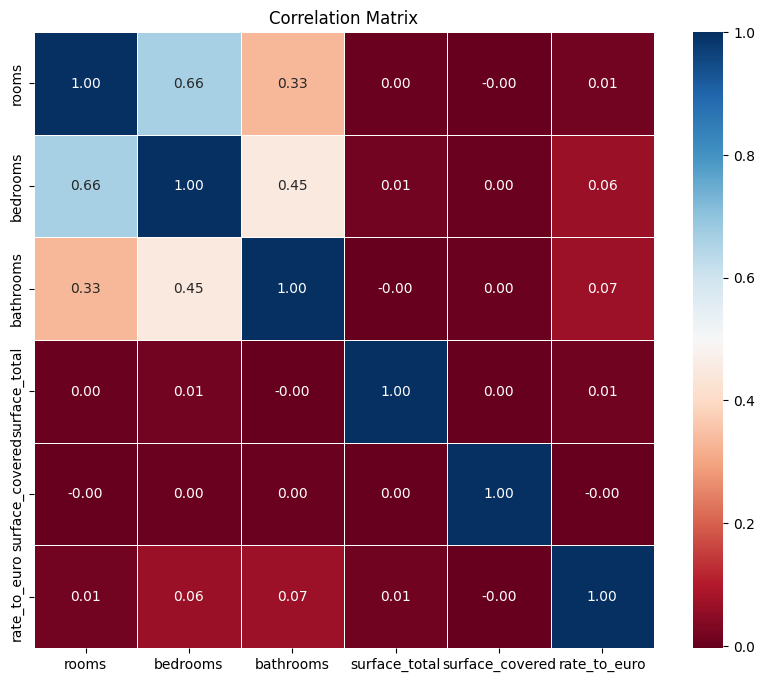

In [58]:
# get numeric columns
numeric = [field.name for field in df.schema.fields if isinstance(field.dataType, (FloatType, IntegerType, DoubleType))]

correlation_matrix = {}

# compute correlations
for col1 in numeric:
    correlation_matrix[col1] = {}
    for col2 in numeric:
        correlation_matrix[col1][col2] = df.stat.corr(col1, col2)

correlation_matrix_df = pd.DataFrame(correlation_matrix)

# plot the heatmap with the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_df, annot=True, cmap='RdBu', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

- Rooms and Bedrooms: There is a strong positive correlation (0.66) between rooms and bedrooms. This suggests that as the number of rooms increases, the number of bedrooms generally increases as well, which is expected.
- Rooms and Bathrooms: There is a moderate positive correlation (0.33) between the number of rooms and bathrooms, indicating that properties with more rooms tend to have more bathrooms.
- Bedrooms and Bathrooms: There is a moderately strong correlation (0.45) here, which is logical since larger homes (with more bedrooms) often have more bathrooms.

=> Using KNNImputer is a robust choice for handling missing data in real estate datasets because it considers the proximity of samples to fill missing values, which is especially suitable given the correlations among rooms, bedrooms, and bathrooms.

Additionally, the imputation improves the dataset's completeness without introducing biases that could affect subsequent analyses or model accuracy.

Get Sample

In [57]:
# sampling 30% of the original df
# colab wouldnt let us convert to pandasDF, more than 30% sample (errors regarding memory)
df_sample = df.sample(fraction=0.3, seed=5)

In [58]:
df_sample.count()

267705

Converting the Spark df to a Pandas df for imputation.

In [59]:
pandas_df = df_sample.toPandas()

In [60]:
pandas_df.shape

(267868, 16)

In [63]:
# apply KNN imputation to fill in missing values
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_rooms = imputer.fit_transform(pandas_df[['bedrooms', 'rooms', 'bathrooms']]) # fit and transform
df_rooms = pd.DataFrame(df_rooms, columns=['bedrooms', 'rooms', 'bathrooms']) # convert the numpy array returned by the imputer to a pandas df

df_rooms.head()

,bedrooms,rooms,bathrooms
0,2.0,3.0,2.0
1,3.0,4.0,2.0
2,3.0,3.6,2.0
3,3.4,5.8,4.0
4,1.6,3.0,1.0


After imputing the rooms we are going to save the rooms_df (which consists only of the 3 columns) and then read it to replace only the desired columns.

In [61]:
pandas_df.shape

(267868, 16)

In [79]:
df_rooms.shape

(267868, 3)

In [73]:
df_rooms.to_csv(google_drive_path + 'df_rooms_only.csv', index = False, sep = ',')  # saving the 0.3% new dataset with the rooms

#### 'Surface_total' and 'surface_covered' KNN imputation

Next, we will impute missing values in 'surface_total' and 'surface_covered' columns ensuring that the total surface area is always logically consistent ('surface_total' should not be less than 'surface_covered').

In [65]:
# KNN imputation
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed_surface = imputer.fit_transform(pandas_df[['surface_total', 'surface_covered']]) # fit and transofmr
df_imputed_surface = pd.DataFrame(df_imputed_surface, columns=['surface_total', 'surface_covered']) # convert the numpy array returned by the imputer to a pandas df
df_imputed_surface['surface_total'] = df_imputed_surface[['surface_total', 'surface_covered']].max(axis=1) # 'surface_total' has to be higher than 'surface_covered'

df_imputed_surface.head()

,surface_total,surface_covered
0,438.173042,347.066038
1,140.000000,140.000000
2,438.173042,347.066038
3,135.000000,135.000000
4,438.173042,347.066038


In [70]:
df_imputed_surface.to_csv(google_drive_path + 'df_surfaces_only.csv', index = False, sep = ',')  # saving the 0.3% new dataset with the surfaces

## Read Imputed Datasets

Now, the next times we run the code, we just read the cvs and replace the columns. We write and read only the imputed columns this time, because with spark we had a lot of difficulties reading and writing the full dataset properly.

In [61]:
rooms_df=pd.read_csv(google_drive_path + "df_rooms_only.csv", sep=",")

In [62]:
rooms_df

,bedrooms,rooms,bathrooms
0,2.00000,3.000000,2.000000
1,3.00000,4.000000,2.000000
2,3.00000,3.600000,2.000000
3,3.40000,5.800000,4.000000
4,1.60000,3.000000,1.000000
...,...,...,...
267863,2.05327,2.840145,1.675326
267864,3.00000,3.200000,3.000000
267865,2.00000,3.000000,1.000000
267866,3.00000,4.000000,2.000000


In [63]:
surfaces_df=pd.read_csv(google_drive_path + "df_surfaces_only.csv", sep=",")

In [64]:
surfaces_df

,surface_total,surface_covered
0,438.173042,347.066038
1,140.000000,140.000000
2,438.173042,347.066038
3,135.000000,135.000000
4,438.173042,347.066038
...,...,...
267863,438.173042,347.066038
267864,85.000000,85.000000
267865,438.173042,347.066038
267866,150.000000,150.000000


In [65]:
# replace the original columns with the imputed ones
pandas_df[['bedrooms', 'rooms', 'bathrooms']] = rooms_df
pandas_df[['surface_total', 'surface_covered']] = surfaces_df

In [66]:
# ensuring once more that 'surface_covered' does not exceed 'surface_total' after imputation
pandas_df = pandas_df[~(pandas_df['surface_covered'] > pandas_df['surface_total'])]
pandas_df.count()

start_date         267868
end_date           267868
created_on         267868
l2                 267868
l3                 267868
rooms              267868
bedrooms           267868
bathrooms          267868
surface_total      267868
surface_covered    267868
title              267868
description        267868
property_type      267868
operation_type     267868
coordinates        267868
amount_in_euro     267868
dtype: int64

In [67]:
# convert pandas df back to spark df
spark_filled = spark.createDataFrame(pandas_df)

spark_filled.show()

+----------+----------+----------+--------------------+---------------+-----------------+------------------+------------------+-----------------+----------------+--------------------+--------------------+-------------+-----------------+--------------------+------------------+
|start_date|  end_date|created_on|                  l2|             l3|            rooms|          bedrooms|         bathrooms|    surface_total| surface_covered|               title|         description|property_type|   operation_type|         coordinates|    amount_in_euro|
+----------+----------+----------+--------------------+---------------+-----------------+------------------+------------------+-----------------+----------------+--------------------+--------------------+-------------+-----------------+--------------------+------------------+
|2019-12-29|2020-07-02|2019-12-29|Buenos Aires Cost...|        Pinamar|              3.0|               2.0|               2.0|438.1730422689701|347.066038471283|       

In [68]:
spark_filled.dtypes

[('start_date', 'date'),
 ('end_date', 'string'),
 ('created_on', 'string'),
 ('l2', 'string'),
 ('l3', 'string'),
 ('rooms', 'double'),
 ('bedrooms', 'double'),
 ('bathrooms', 'double'),
 ('surface_total', 'double'),
 ('surface_covered', 'double'),
 ('title', 'string'),
 ('description', 'string'),
 ('property_type', 'string'),
 ('operation_type', 'string'),
 ('coordinates', 'array<double>'),
 ('amount_in_euro', 'double')]

In [69]:
pandas_df.columns

Index(['start_date', 'end_date', 'created_on', 'l2', 'l3', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'title', 'description',
       'property_type', 'operation_type', 'coordinates', 'amount_in_euro'],
      dtype='object')

## Other Preprocessing after the imputation

In [70]:
spark_filled.count()

267868

In [71]:
spark_filled.show()

+----------+----------+----------+--------------------+---------------+-----------------+------------------+------------------+-----------------+----------------+--------------------+--------------------+-------------+-----------------+--------------------+------------------+
|start_date|  end_date|created_on|                  l2|             l3|            rooms|          bedrooms|         bathrooms|    surface_total| surface_covered|               title|         description|property_type|   operation_type|         coordinates|    amount_in_euro|
+----------+----------+----------+--------------------+---------------+-----------------+------------------+------------------+-----------------+----------------+--------------------+--------------------+-------------+-----------------+--------------------+------------------+
|2019-12-29|2020-07-02|2019-12-29|Buenos Aires Cost...|        Pinamar|              3.0|               2.0|               2.0|438.1730422689701|347.066038471283|       

### Fixing Data Types

In [72]:
# casting all rooms to integer (round down)
spark_filled = spark_filled.withColumn('rooms', spark_filled['rooms'].cast(IntegerType()))
spark_filled = spark_filled.withColumn('bedrooms', spark_filled['bedrooms'].cast(IntegerType()))
spark_filled = spark_filled.withColumn('bathrooms', spark_filled['bathrooms'].cast(IntegerType()))

In [73]:
# round surfaces to 2 decimals
spark_filled = spark_filled.withColumn('surface_total', round(spark_filled.surface_total, 2))
spark_filled = spark_filled.withColumn('surface_covered', round(spark_filled.surface_covered, 2))

In [74]:
spark_filled.show()

+----------+----------+----------+--------------------+---------------+-----+--------+---------+-------------+---------------+--------------------+--------------------+-------------+-----------------+--------------------+------------------+
|start_date|  end_date|created_on|                  l2|             l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|               title|         description|property_type|   operation_type|         coordinates|    amount_in_euro|
+----------+----------+----------+--------------------+---------------+-----+--------+---------+-------------+---------------+--------------------+--------------------+-------------+-----------------+--------------------+------------------+
|2019-12-29|2020-07-02|2019-12-29|Buenos Aires Cost...|        Pinamar|    3|       2|        2|       438.17|         347.07|         PH - Duplex|DUPLEX DE 2 AMBIE...|           PH|Alquiler temporal|[-37.105281829833...|            1099.0|
|2019-12-29|2020-02-11|2019-12-29|Bs

In [75]:
na_counts = spark_filled.select([na_percentage(c, dtype) for c, dtype in df.dtypes])

# print the results in a more readable format - in percentage
for row in na_counts.collect():
    for column, percentage in row.asDict().items():
        print(f"Percentage of NAs in {column}: {percentage:.4f}%")


Percentage of NAs in start_date: 0.0000%
Percentage of NAs in end_date: 0.0000%
Percentage of NAs in created_on: 0.0000%
Percentage of NAs in l2: 0.0000%
Percentage of NAs in l3: 0.0000%
Percentage of NAs in rooms: 0.0000%
Percentage of NAs in bedrooms: 0.0000%
Percentage of NAs in bathrooms: 0.0000%
Percentage of NAs in surface_total: 0.0000%
Percentage of NAs in surface_covered: 0.0000%
Percentage of NAs in title: 0.0000%
Percentage of NAs in description: 0.0000%
Percentage of NAs in property_type: 0.0000%
Percentage of NAs in operation_type: 0.0000%
Percentage of NAs in coordinates: 0.0000%
Percentage of NAs in amount_in_euro: 0.0000%


### Operation_type

In [76]:
spark_filled.groupBy("operation_type").count().show()

+-----------------+------+
|   operation_type| count|
+-----------------+------+
|            Venta|210341|
|         Alquiler| 49569|
|Alquiler temporal|  7958|
+-----------------+------+



We have three different types of housing. For sale, renting and temporary renting. Temporary renting is the minority. Let's check the ranges in price to see if renting and temporary renting have differences. If yes, we are going to drop the houses for temporary renting.

In [77]:
spark_filled.filter((col("operation_type") == "Alquiler")).agg(max("amount_in_euro"), min("amount_in_euro")).show()

+-------------------+-------------------+
|max(amount_in_euro)|min(amount_in_euro)|
+-------------------+-------------------+
|           210680.0|               14.3|
+-------------------+-------------------+



In [78]:
spark_filled.filter((col("operation_type") == "Alquiler temporal")).agg(max("amount_in_euro"), min("amount_in_euro")).show()

+-------------------+-------------------+
|max(amount_in_euro)|min(amount_in_euro)|
+-------------------+-------------------+
|            72800.0|             1.2654|
+-------------------+-------------------+



As we can see, there are differences in prices => we are going to drop them and we are going to focus on more stable long-term data.


In [79]:
spark_filled = spark_filled.filter(col("operation_type") != "Alquiler temporal")

In [80]:
# percentage of na's in each column
na_counts = spark_filled.select([(count(when(col(c).isNull(), c)) / count('*') * 100).alias(c) for c in spark_filled.columns])

# print the results in a more readable format - in percentage
for row in na_counts.collect():
    for column, percentage in row.asDict().items():
        print(f"Percentage of NAs in {column}: {percentage:.8f}%")

Percentage of NAs in start_date: 0.00000000%
Percentage of NAs in end_date: 0.00000000%
Percentage of NAs in created_on: 0.00000000%
Percentage of NAs in l2: 0.00000000%
Percentage of NAs in l3: 0.00000000%
Percentage of NAs in rooms: 0.00000000%
Percentage of NAs in bedrooms: 0.00000000%
Percentage of NAs in bathrooms: 0.00000000%
Percentage of NAs in surface_total: 0.00000000%
Percentage of NAs in surface_covered: 0.00000000%
Percentage of NAs in title: 0.00000000%
Percentage of NAs in description: 0.00000000%
Percentage of NAs in property_type: 0.00000000%
Percentage of NAs in operation_type: 0.00000000%
Percentage of NAs in coordinates: 0.00000000%
Percentage of NAs in amount_in_euro: 0.00000000%


## Dates

### 'created_on', 'start_date'

First, we want to see if the two columns are exactly the same. If yes, we are going to drop one of them.

In [81]:
spark_filled.select('created_on','start_date').show()

+----------+----------+
|created_on|start_date|
+----------+----------+
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
|2019-12-29|2019-12-29|
+----------+----------+
only showing top 20 rows



In [82]:
diff_count = spark_filled.filter(col("created_on") != col("start_date")).count()

# check if there are any rows where the values differ
are_equal = diff_count == 0
print("Have 'created_on' and 'start_date' the same values?", are_equal)

Have 'created_on' and 'start_date' the same values? True


The two columns 'start_date' and 'created_on' are exactly the same so we decided to drop 'created_on'.

In [83]:
# drop the 'created_on' column
spark_filled = spark_filled.drop('created_on')

### 'end_date'

In [84]:
# the end_data seems to have incorrect value of 9999-12-31
spark_filled.orderBy("end_date", ascending=False).select("end_date").show()

+----------+
|  end_date|
+----------+
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
|9999-12-31|
+----------+
only showing top 20 rows



In [85]:
# filter df to see how many values are less than '9999-12-31' in the 'end_date' column
# we are going to keep these values because they are so many, so removing them is not a good idea, and
# additionally they give us info => the ad is still active/the property havent been sold yet
spark_filled.filter(col('end_date') >= '9999-12-31').count()

54992

### Manual Translation

As you have already observed, our dataset is in Spanish. For now we are going to translate manually the property_type and operation_type for easier analysis and interpretability.

In [86]:
# translate property_type
spark_filled = spark_filled.withColumn("property_type",
                   F.when(F.col("property_type") == "Otro", "Other")
                    .when(F.col("property_type") == "Depósito", "Warehouse")
                    .when(F.col("property_type") == "Cochera", "Garage")
                    .when(F.col("property_type") == "Departamento", "Apartment")
                    .when(F.col("property_type") == "Lote", "Lot")
                    .when(F.col("property_type") == "Casa", "House")
                    .when(F.col("property_type") == "PH", "Duplex")
                    .when(F.col("property_type") == "Casa de campo", "Country House")
                    .when(F.col("property_type") == "Oficina", "Office")
                    .when(F.col("property_type") == "Local comercial", "Commercial Space")
                    .otherwise(F.col("property_type"))  # in case of mismatch
                  )



In [87]:
spark_filled.groupBy("property_type").count().show()

+----------------+-----+
|   property_type|count|
+----------------+-----+
|Commercial Space| 8979|
|       Apartment|96897|
|          Office| 7048|
|             Lot|22124|
|   Country House|  347|
|           Other|63958|
|          Garage| 2377|
|       Warehouse| 1715|
|           House|46962|
|          Duplex| 9503|
+----------------+-----+



There is a huge variability among the property_types.

In [88]:
# translate operation type
spark_filled = spark_filled.withColumn("operation_type",
                   F.when(F.col("operation_type") == "Venta", "Sale")
                    .when(F.col("operation_type") == "Alquiler", "Rent")
                    .otherwise(F.col("operation_type"))  # in case of mismatch
                  )


In [89]:
spark_filled.groupBy("operation_type").count().show()

+--------------+------+
|operation_type| count|
+--------------+------+
|          Rent| 49569|
|          Sale|210341|
+--------------+------+



The dataset is not balances, but because we are going to analyse each operation_type as a distinct classification problem, the imbalance does not cause any subsidiary challenges.

## Writing the df

We are going to save the preprocessed df in order not to run the whole code every time. We are going to write it in another format, because we have very complex data (including extremely complex text, arrays) => parquet.

Benefits of Parquet:
- Efficiency: Parquet is highly efficient for both storage and query performance due to its columnar storage format. It compresses data effectively and reduces I/O operations, which is especially beneficial when dealing with large datasets.
- Schema Preservation: Parquet retains the schema along with the data, ensuring that when the data is read back into Spark, all column data types are correctly handled. 
- Compatibility: Parquet is widely supported across data processing frameworks, including Spark, Hadoop, and tools in the AWS and Azure ecosystems. This makes it a versatile choice should you choose to work with different platforms in the future.
- Performance for Analytics: If we need to perform further analytics on the data, Parquet allows for efficient querying because it reads only the necessary columns, thus speeding up operations.

In [90]:
spark_filled.write.format("parquet") \
    .mode("overwrite") \
    .save(google_drive_path + "ar_properties_processed.parquet")

Read the parquet to ensure that everything went well with the writing and reading and we are not going to have any confusions to the next steps.

In [91]:
DF = spark.read.format("parquet") \
    .load(google_drive_path + "ar_properties_processed.parquet")

In [92]:
DF.count()

259910